## IMPORT LIBRARIES

In [83]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import tokenize
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
import spacy
import re
nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Read Data set

In [97]:
df = pd.read_csv('Dataset/raw_Reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62704 entries, 0 to 62703
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             62704 non-null  int64  
 1   en_review          62703 non-null  object 
 2   id                 22804 non-null  float64
 3   language           22804 non-null  object 
 4   additionalRatings  22804 non-null  object 
 5   createdDate        22804 non-null  object 
 6   helpfulVotes       22804 non-null  float64
 7   username           22633 non-null  object 
 8   userId             22696 non-null  object 
 9   title              22803 non-null  object 
 10  text               22804 non-null  object 
 11  locationId         22804 non-null  float64
 12  parentGeoId        22804 non-null  float64
 13  hotelName          22804 non-null  object 
 14  stayDate           22804 non-null  object 
 15  tripType           22804 non-null  object 
 16  en_title           227

In [92]:
df.drop_duplicates(subset=['en_review'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62704 entries, 0 to 62703
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             62704 non-null  int64  
 1   en_review          62703 non-null  object 
 2   id                 22804 non-null  float64
 3   language           22804 non-null  object 
 4   additionalRatings  22804 non-null  object 
 5   createdDate        22804 non-null  object 
 6   helpfulVotes       22804 non-null  float64
 7   username           22633 non-null  object 
 8   userId             22696 non-null  object 
 9   title              22803 non-null  object 
 10  text               22804 non-null  object 
 11  locationId         22804 non-null  float64
 12  parentGeoId        22804 non-null  float64
 13  hotelName          22804 non-null  object 
 14  stayDate           22804 non-null  object 
 15  tripType           22804 non-null  object 
 16  en_title           227

In [98]:
df = df[['rating','en_review']].rename(columns={'en_review':'Review','rating':'Rating'})

In [99]:
df = df.merge(pd.read_csv('Dataset/tripadvisor_hotel_reviews.csv'), how='outer',on=['Rating','Review'])

In [100]:
df.head()

,Rating,Review
0,4,- Located at 4 Ton Duc Thang (in high-class vi...
1,4,"Hana Riverside Quang Ngai hotel, - Located in ..."
2,5,Dropped in here for 1 night on my way north. F...
3,4,Stayed here for one night while passing throug...
4,4,"Nice hotel, staff and facilities but the work ..."


In [102]:
df[['Rating']].value_counts()

Rating
5         54133
4         15853
3          6252
2          3680
1          3277
dtype: int64

# Labeling

In [104]:
df['Sentiment'] = np.select([df['Rating'] > 3, df['Rating'] == 3], [2, 1], 0)

In [105]:
df['Sentiment'].value_counts()

2    69986
0     6957
1     6252
Name: Sentiment, dtype: int64

<Axes: >

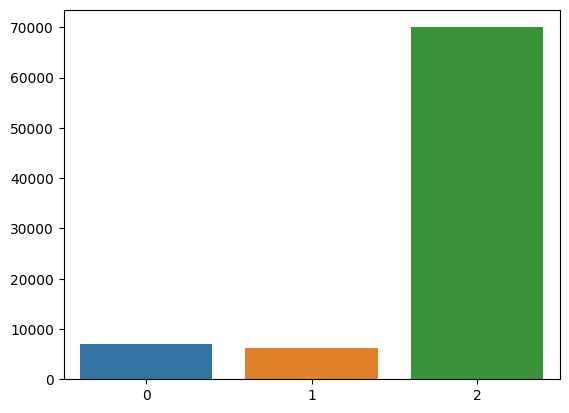

In [107]:
sns.barplot(x=df['Sentiment'].value_counts().index, y=df['Sentiment'].value_counts().values)

# Text Cleaning

In [109]:
df['word_count'] = df['Review'].apply(lambda x: len(str(x).split(" ")))
df[['word_count']].describe()

,word_count
count,83195.000000
mean,118.474824
std,124.174684
min,1.000000
25%,47.000000
50%,78.000000
75%,140.000000
max,3687.000000


In [110]:
df = df[df['word_count'] > 3]

In [111]:
df.head()

,Rating,Review,Sentiment,word_count
0,4,- Located at 4 Ton Duc Thang (in high-class vi...,2,87
1,4,"Hana Riverside Quang Ngai hotel, - Located in ...",2,66
2,5,Dropped in here for 1 night on my way north. F...,2,36
3,4,Stayed here for one night while passing throug...,2,104
4,4,"Nice hotel, staff and facilities but the work ...",2,37


## Lowercase

In [116]:
df.Review = df.Review.str.lower()
df.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_34268\382946222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Review = df.Review.str.lower()


,Rating,Review,Sentiment,word_count
0,4,- located at 4 ton duc thang (in high-class vi...,2,87
1,4,"hana riverside quang ngai hotel, - located in ...",2,66
2,5,dropped in here for 1 night on my way north. f...,2,36
3,4,stayed here for one night while passing throug...,2,104
4,4,"nice hotel, staff and facilities but the work ...",2,37


## Remove punctuation

In [117]:
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [120]:
df['Review'] = df['Review'].astype(str)

C:\Users\DELL\AppData\Local\Temp\ipykernel_34268\2229216485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review'] = df['Review'].astype(str)


In [121]:
df.Review = df.Review.apply(lambda x: " ".join(y for y in x.split() if y not in punctuations))
df.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_34268\2992067707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Review = df.Review.apply(lambda x: " ".join(y for y in x.split() if y not in punctuations))


,Rating,Review,Sentiment,word_count
0,4,located at 4 ton duc thang (in high-class vill...,2,87
1,4,"hana riverside quang ngai hotel, located in a ...",2,66
2,5,dropped in here for 1 night on my way north. f...,2,36
3,4,stayed here for one night while passing throug...,2,104
4,4,"nice hotel, staff and facilities but the work ...",2,37


## Remove non-text

In [123]:
df['Review'] = df['Review'].apply((lambda x: re.sub('[^\w\s]','',x)))
df.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_34268\74921309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review'] = df['Review'].apply((lambda x: re.sub('[^\w\s]','',x)))


,Rating,Review,Sentiment,word_count
0,4,located at 4 ton duc thang in highclass villa ...,2,87
1,4,hana riverside quang ngai hotel located in a q...,2,66
2,5,dropped in here for 1 night on my way north fr...,2,36
3,4,stayed here for one night while passing throug...,2,104
4,4,nice hotel staff and facilities but the work o...,2,37


## Remove stopwords

In [124]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [125]:
stop = stopwords.words('english')

In [126]:
df.Review = df.Review.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df[['Review']].iloc[0]

C:\Users\DELL\AppData\Local\Temp\ipykernel_34268\3126283121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Review = df.Review.apply(lambda x: " ".join(x for x in x.split() if x not in stop))


Review    located 4 ton duc thang highclass villa opposi...
Name: 0, dtype: object

## Lemmatize

In [127]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [129]:
lemmatizer = WordNetLemmatizer()
df['Review'] = df.Review.apply(lambda x: [lemmatizer.lemmatize(x)])

In [132]:
df.to_csv('Dataset/Preprocessed_Reviews.csv', index=False)

## Plotting Frequencies of Words

### Extract all words in a list:

# EDA

In [141]:
corpus = [text for sub in df['Review'] for text in sub]
corpus[:10]
' '.join(corpus[:10])

'located 4 ton duc thang highclass villa opposite tra khuc river 23 km center quang ngai cityhana riverside hotel great choice privacy essentially type villa trading empty rooms like homestaythe room quite spacious good visibilityclean neat hotel built expand outer part rail quite dustyin evening neighbors dog barked night quite noisy affecting sleep hana riverside quang ngai hotel located quiet villa area near river cool 4 km city center clean spacious rooms friendly staff favorite destination tourists motorbike hotel construction outside railing dusty could sleep well night dog next door barked loudly dropped 1 night way north friendly helpful staff clean spacious room great seafood located street within walking distance highly recommend couple nights stayed one night passing room clean tidy kettle fridge good nice clean modern bathroom wasnt best location us find something dinner youre anything standard local food bed comfy main issue got repeatedly woken night dog barking close all

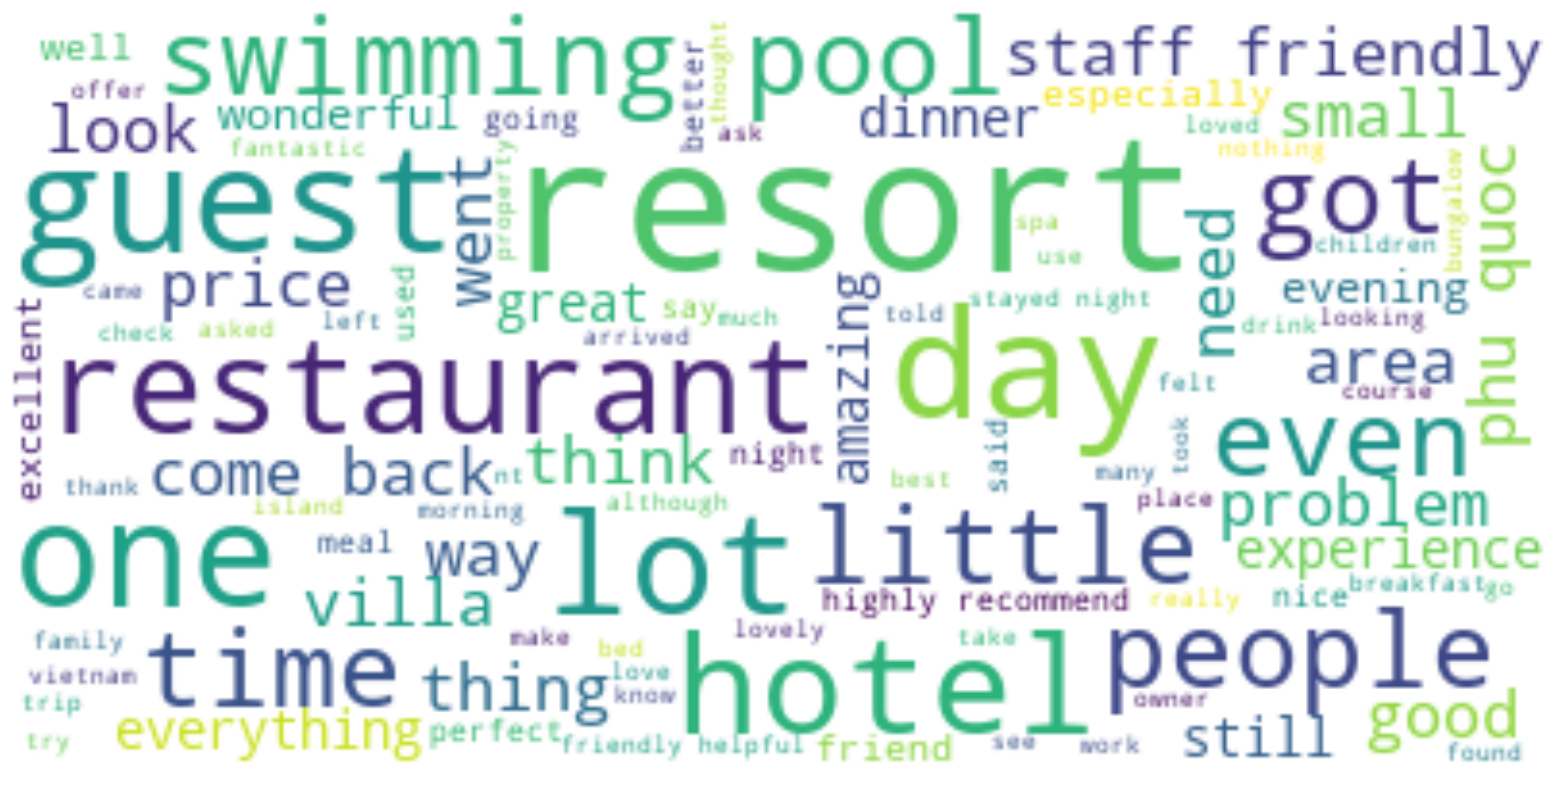

In [142]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join([text for sub in df['Review'] for text in sub]))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [132]:
sns.set_palette(sns.color_palette(['#D09CFA','#2B3467','#BAD7E9','#EB455F','#7DB9B6']))

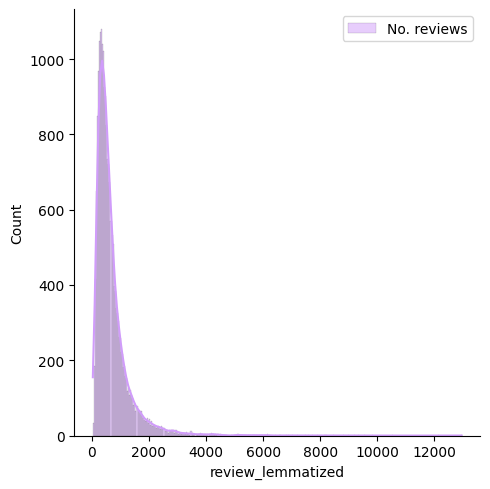

In [133]:
sns.displot(df['review_lemmatized'].apply(lambda x: len(x)), label='No. reviews', kde=True)
plt.legend()
plt.show()

<Axes: xlabel='Sentiment', ylabel='review_lemmatized'>

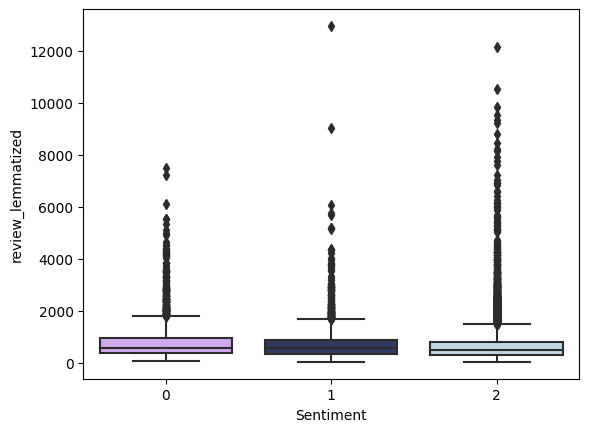

In [134]:
sns.boxplot(x='Sentiment', y=df['review_lemmatized'].apply(lambda x: len(x)), data=df)

In [135]:
df[df['review_lemmatized'].apply(lambda y: len(y)) > 500].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10510 entries, 0 to 20490
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review             10510 non-null  object
 1   Rating             10510 non-null  int64 
 2   Sentiment          10510 non-null  int32 
 3   review_lemmatized  10510 non-null  object
dtypes: int32(1), int64(1), object(2)
memory usage: 369.5+ KB


In [136]:
df = df[df['review_lemmatized'].apply(lambda y: len(y)) < 500]
df.drop(['review_tokenized'], axis=1, inplace=True)
df.info()

KeyError: "['review_tokenized'] not found in axis"

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5')]

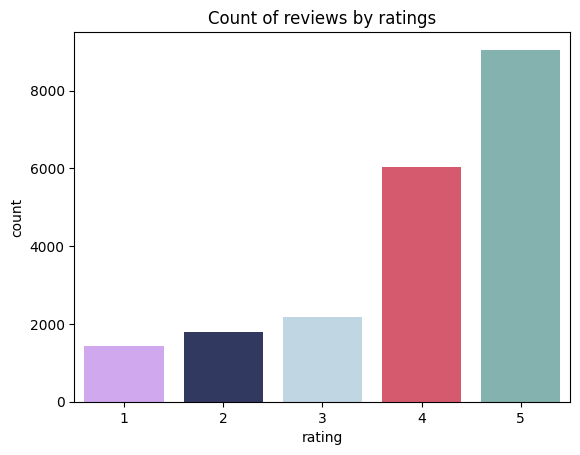

In [ ]:
axs = sns.countplot(x='Rating', data=df)
axs.set_xlabel('rating')
axs.set_title('Count of reviews by ratings')
axs.set_ylabel('count')
axs.set_xticklabels(axs.get_xticklabels(), rotation=0)

In [ ]:
df['Rating'].value_counts()

5    8993
4    5976
3    2161
2    1770
1    1402
Name: Rating, dtype: int64

<Axes: ylabel='Rating'>

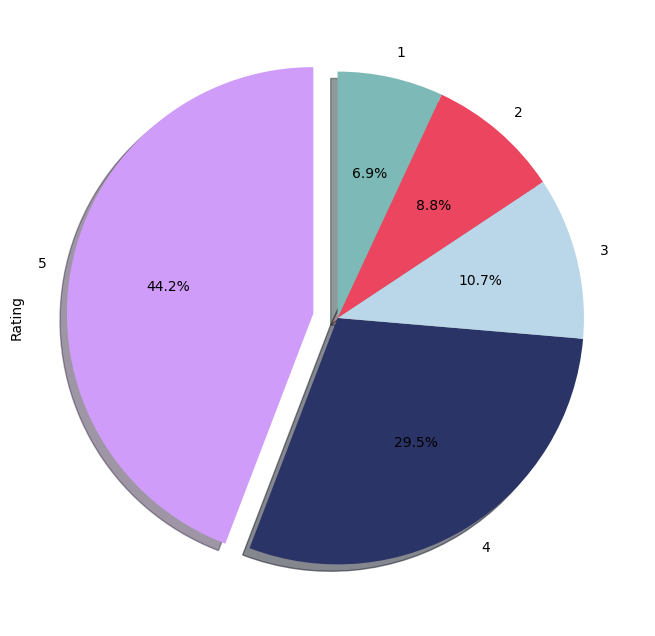

In [ ]:
df['Rating'].value_counts().plot(kind='pie', figsize=(8,8), autopct='%1.1f%%', startangle=90, shadow=True, explode=(0.1,0,0,0,0))

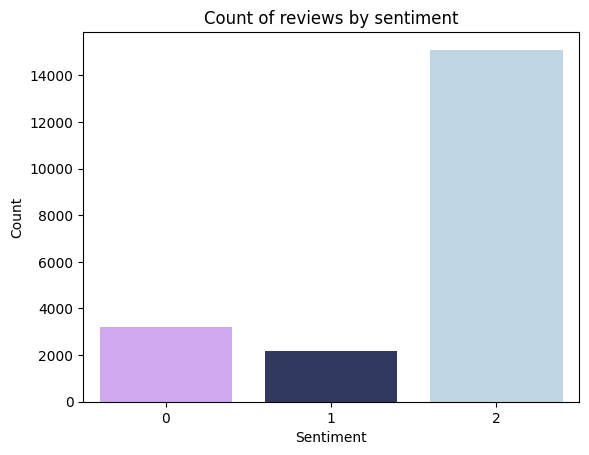

In [ ]:
sns.countplot(x='Sentiment', data=df)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of reviews by sentiment')
plt.show()

In [ ]:
df.drop('Review', axis=1, inplace=True)
df.rename(columns={'review_lemmatized':'review'}, inplace=True)

In [ ]:
df.to_csv('Dataset/tripadvisor_hotel_reviews_cleaned.csv', index=False)